# compare BNB and EXTBNB data to MC-BNB/DATA cosmic overlay 

In [1]:
import sys; sys.path.insert(0, '../../'); sys.path.insert(0,'../mupClassification/')
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from matplotlib.pylab import *
import matplotlib.patches as patches
import pprint; pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline

OffBeam_scaling: 0.706423396358 = N(on beam)/N(off beam) before sof. trig.
MC_scaling_DATAcosmic: 0.516400806804 = N(POT on beam)/N(POT MC)


In [2]:
pd.set_option('precision', 2)

In [3]:
debug = 1
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/OnOffComparisonsPlayground/'

In [4]:
OffBeam = pd.concat([pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_extbnb_v12_mcc8_dev_04_2018_04_06_vertices.csv')
                     ,pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_extbnb_v12_mcc8_dev_05_2018_04_05_vertices.csv')])
OffBeamFV = sample_in_FV(OffBeam)
print len(OffBeam),'pairs from Off-Beam'
print len(OffBeamFV),'pairs from Off-Beam in FV'
print 'OffBeam_scaling',OffBeam_scaling

OnBeam = pd.concat([pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_bnb_v12_unblind_mcc8_04_2018_04_05_vertices.csv')
                     ,pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco_optfilter_bnb_v12_unblind_mcc8_05_2018_04_01_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print len(OnBeam),'pairs from On-Beam'
print len(OnBeamFV),'pairs from On-Beam in FV'
print 'MC_scaling_DATAcosmic',MC_scaling_DATAcosmic


MCbnbDATAcosmicPairsFV, MCbnbDATAcosmicSamples = load_MCbnbDATAcosmicSamples(filename='prodgenie_bnb_nu_uboone_ovrelay_v4_vertices')
print "len(MCbnbDATAcosmicPairsFV['cosmic']):",len(MCbnbDATAcosmicPairsFV['cosmic'])

151 pairs from Off-Beam
89 pairs from Off-Beam in FV
OffBeam_scaling 0.706423396358
38199 pairs from On-Beam
24345 pairs from On-Beam in FV
MC_scaling_DATAcosmic 0.516400806804
27468 pairs from MC-BNB + cosmic DATA overlay
18136 pairs in FV
5060 are 1mu-1p, 27.9%
4071 are other pairs, 22.4%
9005 are cosmic, 49.7%
--------------------------------------------------------------
2389 are CC 1p 0pi, 13.2%
len(MCbnbDATAcosmicPairsFV['cosmic']): 18136
OverlayCosmicScaling: 0.00698186366195


In [12]:
# ------------------------------------------------
# April-4
def gen_Noverlay(reducedSamples=None,cut_name=''
                 ,f_POT = MC_scaling_DATAcosmic
                 ,N_On=len(OnBeamFV) # number of pairs in BeamOn before event-selection cuts
                 ,debug=0
                ):
    # @return the number of events in each subsample of the overlay, POT-normalized
    N = dict()
    N['Cosmic'],N['mup'],N['others'] = float(len(reducedSamples[cut_name]['cosmic'])),float(len(reducedSamples[cut_name]['1mu-1p'])),float(len(reducedSamples[cut_name]['other pairs']))
    N['MC'] = N['mup'] + N['others']
    N['Overlay'] = N['Cosmic'] + N['MC']                     
    N['eff Overlay'] = N['Overlay']/(len(reducedSamples['no cut']['cosmic'])
                                     +len(reducedSamples['no cut']['1mu-1p'])                                     
                                     +len(reducedSamples['no cut']['other pairs']))
    N['Overlay POT Scaled'] = f_POT*(N['Cosmic'] + N['MC'])
    # scale the cosmic in the MC
    N['Cosmic original'] = float(len(reducedSamples['no cut']['cosmic']))
    f_Cosmic = (1./N['Cosmic original'])*(N_On/f_POT - N['MC'])
    N['Cosmic Scaled'] = f_Cosmic*N['Cosmic']
    N['Overlay Cosmic Scaled'] = N['MC'] + N['Cosmic Scaled']
    N['eff Overlay Cosmic Scaled'] = (N['Overlay Cosmic Scaled']
                                      /(f_Cosmic*len(reducedSamples['no cut']['cosmic'])                                                    
                                        +len(reducedSamples['no cut']['1mu-1p'])
                                        +len(reducedSamples['no cut']['other pairs'])))
    N['Overlay Cosmic & POT Scaled'] = f_POT*N['Overlay Cosmic Scaled']
    if debug:         
        print "N['Cosmic original']:",N['Cosmic original']
        print 'N_On:',N_On,',f_Cosmic:',f_Cosmic
        print 'Noverlay in',cut_name
        print N
    return N,f_Cosmic
# ------------------------------------------------

In [16]:
# ------------------------------------------------
# March-6, 2018 (last edit April-7)
def apply_cuts_to_overlay(MCbnbDATAcosmicSamples=None,OverlayCosmicScaling=1
                          ,N_On=1 # number of pairs in BeamOn before event-selection cuts
                          ,do_PIDaCali=False
                          ,PIDa_p_min=13
                          ,minPEcut = 100
                          ,maxdYZcut = 200
                          ,delta_theta_12=55  # deg.
                          ,opt_box=(50,100) # [Nwires x Nticks]
                          ,r_max_RdQ_CC1p0pi = 0.35 # sphere in U,V,Y space, apply a cut only to CC1p0pi
                          ,delta_Delta_phi=35 # deg.
                          ,Pt_max=0.35        # GeV/c
                          ,cuts_order=['no cut']
                          ,debug=0,f_POT = MC_scaling_DATAcosmic
                          ):    

    cut_name = 'no cut'
    reducedSamples = dict()
    pureffOverlay = pd.DataFrame()
    reducedSamples['no cut'] = dict()
    numbers = pd.DataFrame()
    for pair_type in pair_types: reducedSamples['no cut'][pair_type] = MCbnbDATAcosmicSamples[pair_type]
    pureffOverlay = get_pureff_cut(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples ,pureff=pureffOverlay,cut_name=cut_name,reduced=reducedSamples[cut_name])
    Noverlay,_ = gen_Noverlay(reducedSamples=reducedSamples,cut_name=cut_name,N_On=N_On,debug=debug,f_POT=f_POT )
    numbers = numbers.append(pd.DataFrame({ r'$N_{Overlay}$':Noverlay['Overlay']
                                           ,r'${\epsilon}_{Overlay}$ [%]':100                                        
                                           ,r'$N_{Overlay, cosmic-scaled}$':Noverlay['Overlay Cosmic Scaled']
                                           ,r'$N_{Overlay, cosmic-scaled}^{POT-scaled}$':Noverlay['Overlay Cosmic & POT Scaled']
                                           ,r'${\epsilon}_{Overlay, cosmic-scaled}$ [%]':100
                                           ,r'$N_{cosmic}$':Noverlay['Cosmic']
                                           ,r'$N_{cosmic, cosmic-scaled}$':Noverlay['Cosmic Scaled']                                                                                    
                                           ,r'$N_{cosmic, cosmic-scaled}^{POT-scaled}$':f_POT*Noverlay['Cosmic Scaled']                                          
                                          },index=['preselection']))

    
    for i_cut,cut in zip(range(1,len(cuts_order)),cuts_order[1:]):#{
        reduced = dict()
        print 'grabbing reduced samples after (',cuts_order[i_cut-1],') and applying cut on (',cuts_order[i_cut],')'
        samples_previous_cut = reducedSamples[cuts_order[i_cut-1]]
        for pair_type in pair_types:#{
            sam = samples_previous_cut[pair_type]
            
            if cut == 'PIDa':
                if do_PIDaCali:
                    reduced[pair_type] = sam[sam['PIDaCali_assigned_proton']>PIDa_p_min]
                else:
                    reduced[pair_type] = sam[sam['PIDa_assigned_proton']>PIDa_p_min]

            
            elif cut == 'flash':
                reduced[pair_type] = sam[(sam['Nflashes']>0)
                                         &(sam['ClosestFlash_TotalPE'] > minPEcut)
                                         &(sam['ClosestFlash_YZdistance'] < maxdYZcut)]
            
            elif cut == 'length':
                reduced[pair_type] = sam[sam['PIDa_long'] < sam['PIDa_short']]
    
            elif cut == 'non-collinearity':
                reduced[pair_type] = sam[np.abs(sam['theta_12']-90)<delta_theta_12]
            
            elif cut == 'vertex activity':
                R_str = 'RdQaroundVertex'
                box_str='[%d wires x %d ticks]'%(opt_box[0],opt_box[1])
                Ru,Rv,Ry = R_str+'[plane 0]'+box_str,R_str+'[plane 1]'+box_str,R_str+'[plane 2]'+box_str
                reduced[pair_type] = sam[(sam[Ru]==1) | (sam[Rv]==1) | (sam[Ry]==1)
                                         |
                                         (sqrt( np.square(sam[Ru]-1) + square(sam[Rv]-1) + square(sam[Ry]-1) )
                                          <= r_max_RdQ_CC1p0pi) ]
            elif cut == 'delta phi':
                reduced[pair_type] = sam[np.abs(sam['delta_phi']-180.)<delta_Delta_phi]

            elif cut == 'soft Pt':
                reduced[pair_type] = sam[sam['reco_Pt']<Pt_max]
        #}
        reducedSamples[cut] = reduced
        pureffOverlay = get_pureff_cut(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                                       ,pureff=pureffOverlay,cut_name=cut,reduced=reduced)
    #}
        Noverlay,_ = gen_Noverlay(reducedSamples=reducedSamples,cut_name=cut,N_On=N_On,debug=debug,f_POT=f_POT )
        numbers = numbers.append(pd.DataFrame({ r'$N_{Overlay}$':Noverlay['Overlay']
                                           ,r'${\epsilon}_{Overlay}$ [%]':100.*Noverlay['eff Overlay']
                                           ,r'$N_{Overlay, cosmic-scaled}$':Noverlay['Overlay Cosmic Scaled']
                                           ,r'$N_{Overlay, cosmic-scaled}^{POT-scaled}$':Noverlay['Overlay Cosmic & POT Scaled']
                                           ,r'${\epsilon}_{Overlay, cosmic-scaled}$ [%]':100.*Noverlay['eff Overlay Cosmic Scaled']
                                           ,r'$N_{cosmic}$':Noverlay['Cosmic']
                                           ,r'$N_{cosmic, cosmic-scaled}$':Noverlay['Cosmic Scaled']                                                                                    
                                           ,r'$N_{cosmic, cosmic-scaled}^{POT-scaled}$':f_POT*Noverlay['Cosmic Scaled']                                          
                                          },index=[cut]))
    return reducedSamples,pureffOverlay,numbers
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -



In [24]:
# cuts_pureff = apply_cuts_MCbnbDATAcosmic()
cuts_pureff = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,do_PIDaCali=True
                                    ,OverlayCosmicScaling=OverlayCosmicScaling
                                    ,cuts_order  = ['no cut','PIDa','flash','length','vertex activity','delta phi','soft Pt'] )
reducedSamples,pureff_MCbnbDATAcosmic,pureff_MCbnbDATAcosmic_numbers = cuts_pureff
pureff_MCbnbDATAcosmic

Noverlay['Overlay']: 18136.0
grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
grabbing reduced samples after ( flash ) and applying cut on ( length )
grabbing reduced samples after ( length ) and applying cut on ( vertex activity )
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
grabbing reduced samples after ( delta phi ) and applying cut on ( soft Pt )


,$\mu p$ eff.,$\mu p$ pur.,CC$0\pi 1 p$ eff.,CC$0\pi 1 p$ pur.,label,1mu-1p,other pairs,cosmic,CC 1p 0pi
no cut,100.0%,27.9%,100.0%,13.2%,no cut,100.0% (5060),100.0% (4071),100.0% (9005),100.0% (2389)
PIDa,83.9%,52.8%,86.3%,25.7%,PIDa,83.9% (4246),59.2% (2412),15.3% (1380),86.3% (2062)
flash,78.9%,57.4%,81.0%,27.8%,flash,78.9% (3992),56.9% (2315),7.2% (650),81.0% (1934)
length,69.4%,67.4%,72.9%,33.5%,length,69.4% (3510),32.5% (1324),4.1% (370),72.9% (1742)
vertex activity,45.7%,70.0%,62.4%,45.1%,vertex activity,45.7% (2314),20.0% (816),1.9% (175),62.4% (1490)
delta phi,30.1%,83.2%,46.5%,60.6%,delta phi,30.1% (1525),5.6% (228),0.9% (80),46.5% (1111)
soft Pt,25.7%,88.8%,41.3%,67.6%,soft Pt,25.7% (1298),3.1% (127),0.4% (36),41.3% (987)


In [10]:
# cuts_pureff = apply_cuts_MCbnbDATAcosmic()
cuts_pureff = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                                    ,OverlayCosmicScaling=OverlayCosmicScaling)
reducedSamples,pureff_MCbnbDATAcosmic,pureff_MCbnbDATAcosmic_numbers = cuts_pureff
pureff_MCbnbDATAcosmic

grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
grabbing reduced samples after ( flash ) and applying cut on ( length )
grabbing reduced samples after ( length ) and applying cut on ( non-collinearity )
grabbing reduced samples after ( non-collinearity ) and applying cut on ( vertex activity )
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
grabbing reduced samples after ( delta phi ) and applying cut on ( soft Pt )


,$\mu p$ eff.,$\mu p$ pur.,CC$0\pi 1 p$ eff.,CC$0\pi 1 p$ pur.,label,1mu-1p,other pairs,cosmic,CC 1p 0pi
no cut,100.0%,26.9%,100.0%,13.3%,no cut,100.0% (5087),100.0% (4335),100.0% (9486),100.0% (2514)
PIDa,85.4%,53.6%,84.5%,26.2%,PIDa,85.4% (4345),55.3% (2398),14.4% (1368),84.5% (2124)
flash,80.4%,57.9%,79.3%,28.3%,flash,80.4% (4089),53.2% (2306),7.0% (662),79.3% (1994)
length,66.6%,67.4%,69.5%,34.7%,length,66.6% (3390),29.3% (1271),3.9% (370),69.5% (1746)
non-collinearity,59.7%,73.4%,64.6%,39.3%,non-collinearity,59.7% (3039),20.7% (899),2.1% (202),64.6% (1625)
vertex activity,40.7%,76.9%,55.5%,51.9%,vertex activity,40.7% (2068),11.8% (513),1.1% (107),55.5% (1395)
delta phi,27.1%,90.6%,42.5%,70.3%,delta phi,27.1% (1377),2.7% (118),0.3% (25),42.5% (1069)
soft Pt,23.8%,93.0%,38.2%,73.8%,soft Pt,23.8% (1210),1.7% (75),0.2% (16),38.2% (960)


In [27]:

# ------------------------------------------------
# March-6, 2018 (last edit March 29)
def apply_cuts_to_data(PIDa_p_min=13,do_PIDaCali=False
                       ,minPEcut = 100
                       ,maxdYZcut = 200
                       ,delta_theta_12=55  # deg.
                       ,opt_box=(50,100) # [Nwires x Nticks]
                       ,r_max_RdQ_CC1p0pi = 0.35 # sphere in U,V,Y space, apply a cut only to CC1p0pi
                       ,delta_Delta_phi=35 # deg.
                       ,Pt_max=0.35        # GeV/c
                       ,OnBeamFV=None,OffBeamFV=None
                       ,cuts_order=['no cut','PIDa','flash','length','non-collinearity','vertex activity','delta phi','soft Pt']
                       ,debug=0
                       ):
    reducedOnBeam, reducedOffBeam = dict(), dict()
    
    reducedOnBeam['no cut'] = OnBeamFV
    reducedOffBeam['no cut'] = OffBeamFV
    numbers = pd.DataFrame()

    numbers = numbers.append(pd.DataFrame({'$N_{On}$':len(OnBeamFV)
                                           ,r'${\epsilon}_{On}$ [%]':100.                                           
                                           ,'$N_{Off}$':len(OffBeamFV)
                                           ,r'${\epsilon}_{Off}$ [%]':100.                                              
                                           ,'$N_{On-Off}$':(len(OnBeamFV)-OffBeam_scaling*len(OffBeamFV))
                                           ,r'${\epsilon}_{On-Off}$ [%]':100
                                           ,'$N_{Off}^{scaled}$':OffBeam_scaling*len(OffBeamFV)
                                         },index=['preselection']))

    for i_cut,cut in zip(range(1,len(cuts_order)),cuts_order[1:]):#{
        if debug: print 'grabbing reduced data samples after (',cuts_order[i_cut-1],') and applying cut on (',cuts_order[i_cut],')'
        OnBeam_previous_cut = reducedOnBeam[cuts_order[i_cut-1]]
        OffBeam_previous_cut = reducedOffBeam[cuts_order[i_cut-1]]
        
        for sam,sam_name in zip([OnBeam_previous_cut,OffBeam_previous_cut]
                                ,['OnBeam','OffBeam']):#{
            if debug: print 'len('+sam_name+'):',len(sam)
            if cut == 'PIDa':
                if do_PIDaCali:
                    sam = sam[sam['PIDaCali_assigned_proton']>PIDa_p_min]
                else:
                    sam = sam[sam['PIDa_assigned_proton']>PIDa_p_min]
            
            elif cut == 'flash':
                sam = sam[(sam['Nflashes']>0)
                          &(sam['ClosestFlash_TotalPE'] > minPEcut)
                          &(sam['ClosestFlash_YZdistance'] < maxdYZcut)]
            
            elif cut == 'length':
                sam = sam[sam['PIDa_long'] < sam['PIDa_short']]
    
            elif cut == 'non-collinearity':
                sam = sam[np.abs(sam['theta_12']-90)<delta_theta_12]
                    
            elif cut == 'vertex activity':
                R_str = 'RdQaroundVertex'
                box_str='[%d wires x %d ticks]'%(opt_box[0],opt_box[1])
                Ru,Rv,Ry = R_str+'[plane 0]'+box_str,R_str+'[plane 1]'+box_str,R_str+'[plane 2]'+box_str
                sam = sam[(sam[Ru]==1) | (sam[Rv]==1) | (sam[Ry]==1)
                          |
                          (sqrt( np.square(sam[Ru]-1) + square(sam[Rv]-1) + square(sam[Ry]-1) )
                           <= r_max_RdQ_CC1p0pi) ]
            elif cut == 'delta phi':
                sam = sam[np.abs(sam['delta_phi']-180.)<delta_Delta_phi]
                                      
            elif cut == 'soft Pt':
                sam = sam[sam['reco_Pt']<Pt_max]
                                              
            if sam_name=='OnBeam': reducedOnBeam[cut] = sam
            if sam_name=='OffBeam': reducedOffBeam[cut] = sam
        #}
        numbers = numbers.append(pd.DataFrame({'$N_{On}$':len(reducedOnBeam[cut])                                               
                                               ,r'${\epsilon}_{On}$ [%]':(100.*float(len(reducedOnBeam[cut]))/len(OnBeamFV))                                               
                                               ,'$N_{Off}$':len(reducedOffBeam[cut])
                                               ,r'${\epsilon}_{Off}$ [%]':(100.*float(len(reducedOffBeam[cut]))/len(OffBeamFV))
                                              ,'$N_{On-Off}$':(len(reducedOnBeam[cut])-OffBeam_scaling*len(reducedOffBeam[cut]))
                                              ,r'${\epsilon}_{On-Off}$ [%]':(100*(len(reducedOnBeam[cut])-OffBeam_scaling*len(reducedOffBeam[cut]))                                                           
                                                                      /(len(OnBeamFV)-OffBeam_scaling*len(OffBeamFV)))
                                               ,'$N_{Off}^{scaled}$':OffBeam_scaling*len(reducedOffBeam[cut])
                                              }
                                             ,index=[cut]))
    #}
    return reducedOnBeam,reducedOffBeam,numbers
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -


# Reweight the cosmic in the overlay to match the OffBeam before any post-selection cuts, and then check what happens to the On-Off beam after all cuts

In [28]:
cuts_order  = ['no cut','PIDa','flash','length','vertex activity','delta phi','soft Pt'] 
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut'] 

reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order,do_PIDaCali=True)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order,do_PIDaCali=True)
print 'done applying cuts to data'

Noverlay['Overlay']: 18136.0
grabbing reduced samples after ( no cut ) and applying cut on ( PIDa )
grabbing reduced samples after ( PIDa ) and applying cut on ( flash )
grabbing reduced samples after ( flash ) and applying cut on ( length )
grabbing reduced samples after ( length ) and applying cut on ( vertex activity )
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
grabbing reduced samples after ( delta phi ) and applying cut on ( soft Pt )
done applying cuts to overlay
done applying cuts to data


# overlay subsamples-scaling

In [58]:
f_Cosmic=0.92
overlay_scalings = dict()
overlay_scalings['only POT'] = get_samples_scaling( N_total='MC(tot) x POT' # total integral of all overlay 
                                      , f_Cosmic=None  # fraction of cosmic in the overlay, need to be in the range 0-1
                                      , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
overlay_scalings['POT scaling and f(cosmic)=%.2f'%f_Cosmic] = get_samples_scaling( N_total='MC(tot) x POT'  # total integral of all overlay                                       
                                                                         , f_Cosmic=f_Cosmic  # fraction of cosmic in the overlay, need to be in the range 0-1
                                                                         , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
overlay_scalings['N(On) scaling'] = get_samples_scaling( N_total= float(len(OnBeamFV)) # total integral of all overlay                                       
                                               , f_Cosmic=None  # fraction of cosmic in the overlay, need to be in the range 0-1
                                               , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic] = get_samples_scaling( N_total= float(len(OnBeamFV)) # total integral of all overlay                                       
                                                                         , f_Cosmic=f_Cosmic  # fraction of cosmic in the overlay, need to be in the range 0-1
                                                                         , OverlaySubsamples=reducedOverlay['no cut'], debug=2, f_POT=MC_scaling_DATAcosmic)
print 'overlay scalings';pp.pprint(overlay_scalings)

N
{   '1mu-1p': 5087.0,
    'CC 1p 0pi': 2514.0,
    'MC': 9422.0,
    'cosmic': 9486.0,
    'other pairs': 4335.0,
    'total': 9764.1064550522769}
f
{   '1mu-1p in MC': 0.5399066015707917,
    'CC 1p 0pi in MC': 0.26682233071534706,
    'Cosmic': 0.5016924053310768,
    'MC': 0.49830759466892316,
    'other pairs in MC': 0.4600933984292082}
scaling:
{   '1mu-1p': 0.5164008068041186,
    'CC 1p 0pi': 0.51640080680411871,
    'cosmic': 0.51640080680411882,
    'other pairs': 0.51640080680411871}
N
{   '1mu-1p': 5087.0,
    'CC 1p 0pi': 2514.0,
    'MC': 9422.0,
    'cosmic': 9486.0,
    'other pairs': 4335.0,
    'total': 9764.1064550522769}
f
{   '1mu-1p in MC': 0.5399066015707917,
    'CC 1p 0pi in MC': 0.26682233071534706,
    'Cosmic': 0.92,
    'MC': 0.07999999999999996,
    'other pairs in MC': 0.4600933984292082}
scaling:
{   '1mu-1p': 0.082904745956716375,
    'CC 1p 0pi': 0.082904745956716375,
    'cosmic': 0.94697216304533993,
    'other pairs': 0.082904745956716375}
N
{   '1

In [76]:
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -
# Nov-20,2017 (last editted Marc-20, 2018)
def plot_stacked_MCsamples( ax=None, debug=0,overlay_scaling=None
                           , reducedOverlay=None, cut_name='no cut'
                           , MCbnbDATAcosmicSamples=None
                           , var=None, x_label='',y_label='', bins=None , alpha=0.8, fontsize=25
                           , remove_ticks_x=False
                           , remove_ticks_y=False , xlim=None
                           , do_add_legend=False
                           , do_individual_histograms=True,stackColor='black',stackLabel='MC'):
    '''
    return: h, bins
            stacked histogram values and bins,
            of the samples from the overlay: 
            (cosmic, other-pairs) + 1mu 1p pairs
    '''
    bin_width = bins[1]-bins[0]    
    mid = 0.5*(bins[:-1]+bins[1:])
    h,labels,colors,N = dict(),dict(),dict(),dict()    

    for i_pair_type,pair_type in enumerate(pair_types):
        sample = reducedOverlay[cut_name][pair_type]
        N[pair_type] = float(len(sample))
        Noriginal = len(MCbnbDATAcosmicSamples[pair_type])
        labels[pair_type] = MClabels[i_pair_type]+' (%.1f=%.1f'%(N[pair_type],100.*N[pair_type]/Noriginal)+'%)'
        colors[pair_type] = MCcolors[i_pair_type];
        x = sample[var]
        h[pair_type],edges = np.histogram(x,bins=bins)
        h[pair_type+' scaled'] = overlay_scaling[pair_type]*h[pair_type]
    # -- - - - --------- - - -- ---- -  - --- -- -- -- --
    
    if debug>1: 
        print "stacked_MCsamples (bins[:-1]):\n",bins[:-1]
        print "np.sum(h['cosmic']):",np.sum(h['cosmic'])
        print "np.sum(h['cosmic scaled']):",np.sum(h['cosmic scaled'])
        print "np.sum(h['1mu-1p']):",np.sum(h['1mu-1p'])
        print "np.sum(h['1mu-1p scaled']):",np.sum(h['1mu-1p scaled'])
        print "np.sum(h['other pairs']):",np.sum(h['other pairs'])

    if do_individual_histograms:
        # mu-p  
        plt.bar(mid,h['cosmic scaled']+h['other pairs scaled']+h['1mu-1p scaled'] , width=bin_width
                         ,color=colors['1mu-1p'],alpha=alpha, label=labels['1mu-1p'])
        # CC 1p 0pi
        plt.bar(mid,h['cosmic scaled']+h['other pairs scaled']+h['CC 1p 0pi scaled'] , width=bin_width
                         ,color=colors['CC 1p 0pi'],alpha=alpha, label=labels['CC 1p 0pi'])
        # other pairs
        plt.bar(mid,h['cosmic scaled']+h['other pairs scaled'] , width=bin_width
                         ,color=colors['other pairs'],alpha=alpha , label=labels['other pairs'])
        # cosmic
        plt.bar(mid, h['cosmic scaled'] , width=bin_width
                         ,color=colors['cosmic'],alpha=alpha, label=labels['cosmic'])
    
    # all
    h_stack = h['cosmic scaled']+h['other pairs scaled']+h['1mu-1p scaled']
    plt.step(mid+0.5*bin_width,h_stack ,color=stackColor,alpha=alpha, label=stackLabel)
        

    if np.max(h_stack)>np.max(ax.get_ylim()): ax.set_ylim(np.min(ax.get_ylim()),1.05*np.max(h_stack))
    set_axes(ax,x_label=x_label,y_label=y_label,do_add_grid=True,fontsize=fontsize,do_add_legend=do_add_legend
             ,xlim=(np.min(bins)-0.5*bin_width,np.max(bins)+0.5*bin_width) if xlim is None else xlim
             ,remove_ticks_x=remove_ticks_x             
             ,remove_ticks_y=remove_ticks_y                 
            )    
    return h_stack , bins
# -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- - -- - - -- -- - -- -

In [77]:
def get_samples_scaling( N_total=1 # total integral of all overlay 
                        , f_Cosmic=None  # fraction of cosmic in the overlay, need to be in the range 0-1
                        , OverlaySubsamples=None
                        , debug=0
                        , f_POT=MC_scaling_DATAcosmic):
    # return the total scaling factor of each of the overlay subsamples
    scaling,N,f = dict(),dict(),dict()
    
    for pair_type in pair_types: N[pair_type] = float(len(OverlaySubsamples[pair_type]))
    N['MC'] = N['1mu-1p']+N['other pairs']
    if N_total=='MC(tot) x POT':
        N['total']=(N['MC']+N['cosmic'])*f_POT
    else:
        N['total']=N_total
    
    if f_Cosmic is None:
        f['Cosmic'] = N['cosmic']/(N['MC']+N['cosmic'])
    else:
        f['Cosmic'] = f_Cosmic
    f['MC'] = 1-f['Cosmic']
        
    f['1mu-1p in MC'] = N['1mu-1p']/N['MC']
    f['CC 1p 0pi in MC'] = N['CC 1p 0pi']/N['MC']
    f['other pairs in MC'] = N['other pairs']/N['MC']
                
    # f_Cosmic = fraction of cosmic in the overlay
    scaling['cosmic']     = N['total']*f['Cosmic']/N['cosmic']
    scaling['other pairs']= N['total']*f['MC']*f['other pairs in MC']/N['other pairs']
    scaling['1mu-1p']     = N['total']*f['MC']*f['1mu-1p in MC']/N['1mu-1p']
    scaling['CC 1p 0pi']  = N['total']*f['MC']*f['CC 1p 0pi in MC']/N['CC 1p 0pi']
    
    if debug: 
        print 'N';pp.pprint(N)
        print 'f';pp.pprint(f)
        print 'scaling:';pp.pprint(scaling)
    return scaling

## collinearity

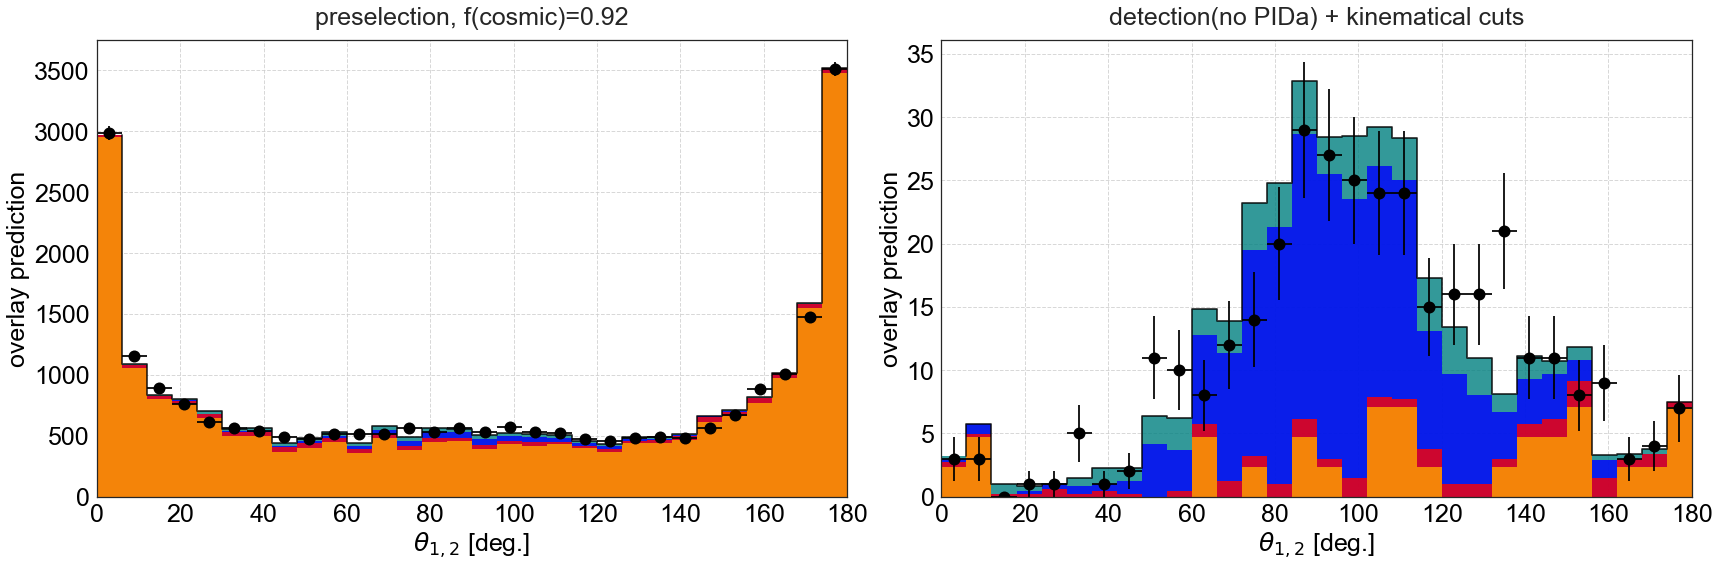

In [85]:

var,x_label,bins='theta_12', r'$\theta_{1,2}$ [deg.]',np.linspace(0,180,31)
x_ticks = [0,50,100,150]
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,2,1)
cut_name,cut_label='no cut','preselection'
_,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam[cut_name],OnBeamFV=reducedOnBeam['no cut'],color='black'
                 , var=var, x_label='', bins=bins, ax=ax , y_label='On Beam'
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=False, do_OffBeam_scaling=True)
h_stack,_=plot_stacked_MCsamples( debug=0,overlay_scaling=overlay_scalings['N(On) scaling and f(cosmic)=0.92']
                                 , cut_name=cut_name
                                 , reducedOverlay=reducedOverlay
                                 , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
                                 , var=var, x_label=x_label, y_label='overlay prediction',xlim=(0,180)
                                 , bins=bins , alpha=0.8, ax=ax
                                 , do_add_legend=False
                                );
ax.set_title(cut_label+', f(cosmic)=%.2f'%f_Cosmic if f_Cosmic is not None else '',y=1.02,fontsize=25)

ax = fig.add_subplot(1,2,2)
cut_name,cut_label='soft Pt','detection(no PIDa) + kinematical cuts'
ax.set_title(cut_label,y=1.02,fontsize=25)
_,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam[cut_name],OnBeamFV=reducedOnBeam['no cut'],color='black'
                 , var=var, x_label='', bins=bins, ax=ax , y_label='On Beam'
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=False, do_OffBeam_scaling=True)

for scaling_name,scaling_color in zip(['N(On) scaling and f(cosmic)=0.92']#,'N(On) scaling','only POT','POT scaling and f(cosmic)=0.92']
                                      ,['black','blue','red','forestgreen']):
    h_stack,_= plot_stacked_MCsamples( debug=0, overlay_scaling=overlay_scalings[scaling_name]
                                      , stackColor=scaling_color, stackLabel=scaling_name
                                      , cut_name=cut_name
                                      , reducedOverlay=reducedOverlay
                                      , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
                                      , var=var, x_label=x_label, y_label='overlay prediction',xlim=(0,180)
                                      , bins=bins , alpha=0.8, ax=ax
                                      , do_individual_histograms=True if scaling_name=='N(On) scaling and f(cosmic)=0.92' else False
                                      , do_add_legend=False);

plt.tight_layout()

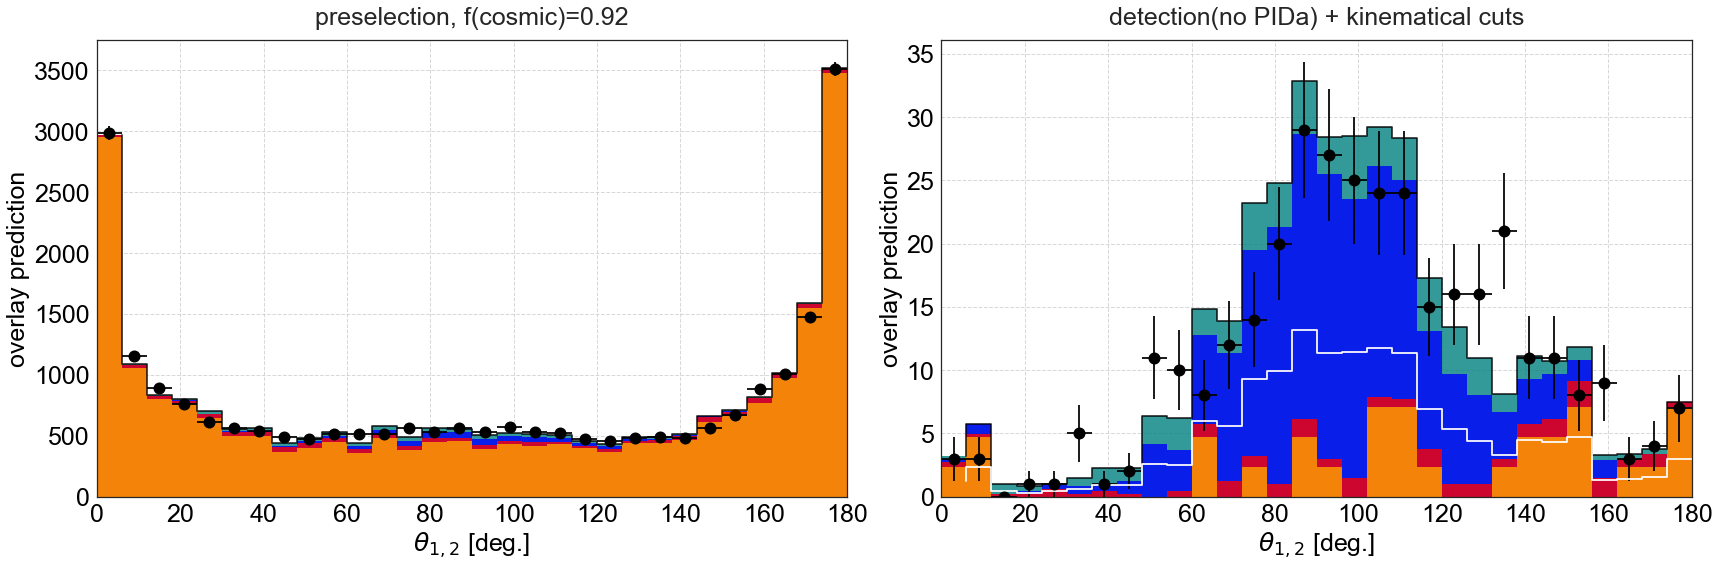

In [53]:

var,x_label,bins='theta_12', r'$\theta_{1,2}$ [deg.]',np.linspace(0,180,31)
x_ticks = [0,50,100,150]
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,2,1)
cut_name,cut_label='no cut','preselection'
# _,h_OffBeam = plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut'],color='white'
#                  , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam'
#                  , do_add_legend=False , legend_loc='best',remove_ticks_x=False, do_OffBeam_scaling=True)
_,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam[cut_name],OnBeamFV=reducedOnBeam['no cut'],color='black'
                 , var=var, x_label='', bins=bins, ax=ax , y_label='On Beam'
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=False, do_OffBeam_scaling=True)
h_stack,_=plot_stacked_MCsamples( debug=0,overlay_scaling=overlay_scaling
                                 , cut_name=cut_name
                                 , reducedOverlay=reducedOverlay
                                 , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
                                 , var=var, x_label=x_label, y_label='overlay prediction',xlim=(0,180)
                                 , bins=bins , alpha=0.8, ax=ax
                                 , do_add_legend=False
                                );
ax.set_title(cut_label+', f(cosmic)=%.2f'%f_Cosmic if f_Cosmic is not None else '',y=1.02,fontsize=25)

ax = fig.add_subplot(1,2,2)
cut_name,cut_label='soft Pt','detection(no PIDa) + kinematical cuts'
ax.set_title(cut_label,y=1.02,fontsize=25)
# ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True                                   
#                            ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']                           
#                            ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']                           
#                            ,do_add_MCoverlay=False , y_label='On Beam - Off Beam'
#                            ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False)  
# _,h_OffBeam = plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut'],color='white'
#                  , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam'
#                  , do_add_legend=False , legend_loc='best',remove_ticks_x=False, do_OffBeam_scaling=True)
_,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam[cut_name],OnBeamFV=reducedOnBeam['no cut'],color='black'
                 , var=var, x_label='', bins=bins, ax=ax , y_label='On Beam'
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=False, do_OffBeam_scaling=True)

h_stack,_= plot_stacked_MCsamples( debug=0, overlay_scaling=overlay_scaling
                                 , cut_name=cut_name
                                 , reducedOverlay=reducedOverlay
                                 , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
                                 , var=var, x_label=x_label, y_label='overlay prediction',xlim=(0,180)
                                 , bins=bins , alpha=0.8, ax=ax
                                 , do_add_legend=False);

h_stack,_= plot_stacked_MCsamples( debug=0,overlay_scaling=POT_scaling,stackColor='white'
                                 , cut_name=cut_name
                                 , reducedOverlay=reducedOverlay
                                 , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
                                 , var=var, x_label=x_label, y_label='overlay prediction',xlim=(0,180)
                                 , bins=bins , alpha=1, ax=ax
                                 , do_add_legend=False
                                  , do_individual_histograms=False );

# h_stack,_= plot_stacked_MCsamples( debug=0,overlay_scaling=no_scaling,stackColor='red'
#                                  , cut_name=cut_name
#                                  , reducedOverlay=reducedOverlay
#                                  , MCbnbDATAcosmicSamples = MCbnbDATAcosmicSamples
#                                  , var=var, x_label=x_label, y_label='overlay prediction',xlim=(0,180)
#                                  , bins=bins , alpha=1, ax=ax
#                                  , do_add_legend=False
#                                   , do_individual_histograms=False );


plt.tight_layout()

# study the evolution of PIDa(p) in On-Off beam without applying the PIDa(p) cut

Noverlay['Overlay']: 18136.0
grabbing reduced samples after ( no cut ) and applying cut on ( flash )
grabbing reduced samples after ( flash ) and applying cut on ( length )
grabbing reduced samples after ( length ) and applying cut on ( non-collinearity )
grabbing reduced samples after ( non-collinearity ) and applying cut on ( vertex activity )
grabbing reduced samples after ( vertex activity ) and applying cut on ( delta phi )
grabbing reduced samples after ( delta phi ) and applying cut on ( soft Pt )
done applying cuts to overlay
done applying cuts to data
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/OnOffComparisonsPlayground/PIDaCali_proton_with_cuts.pdf


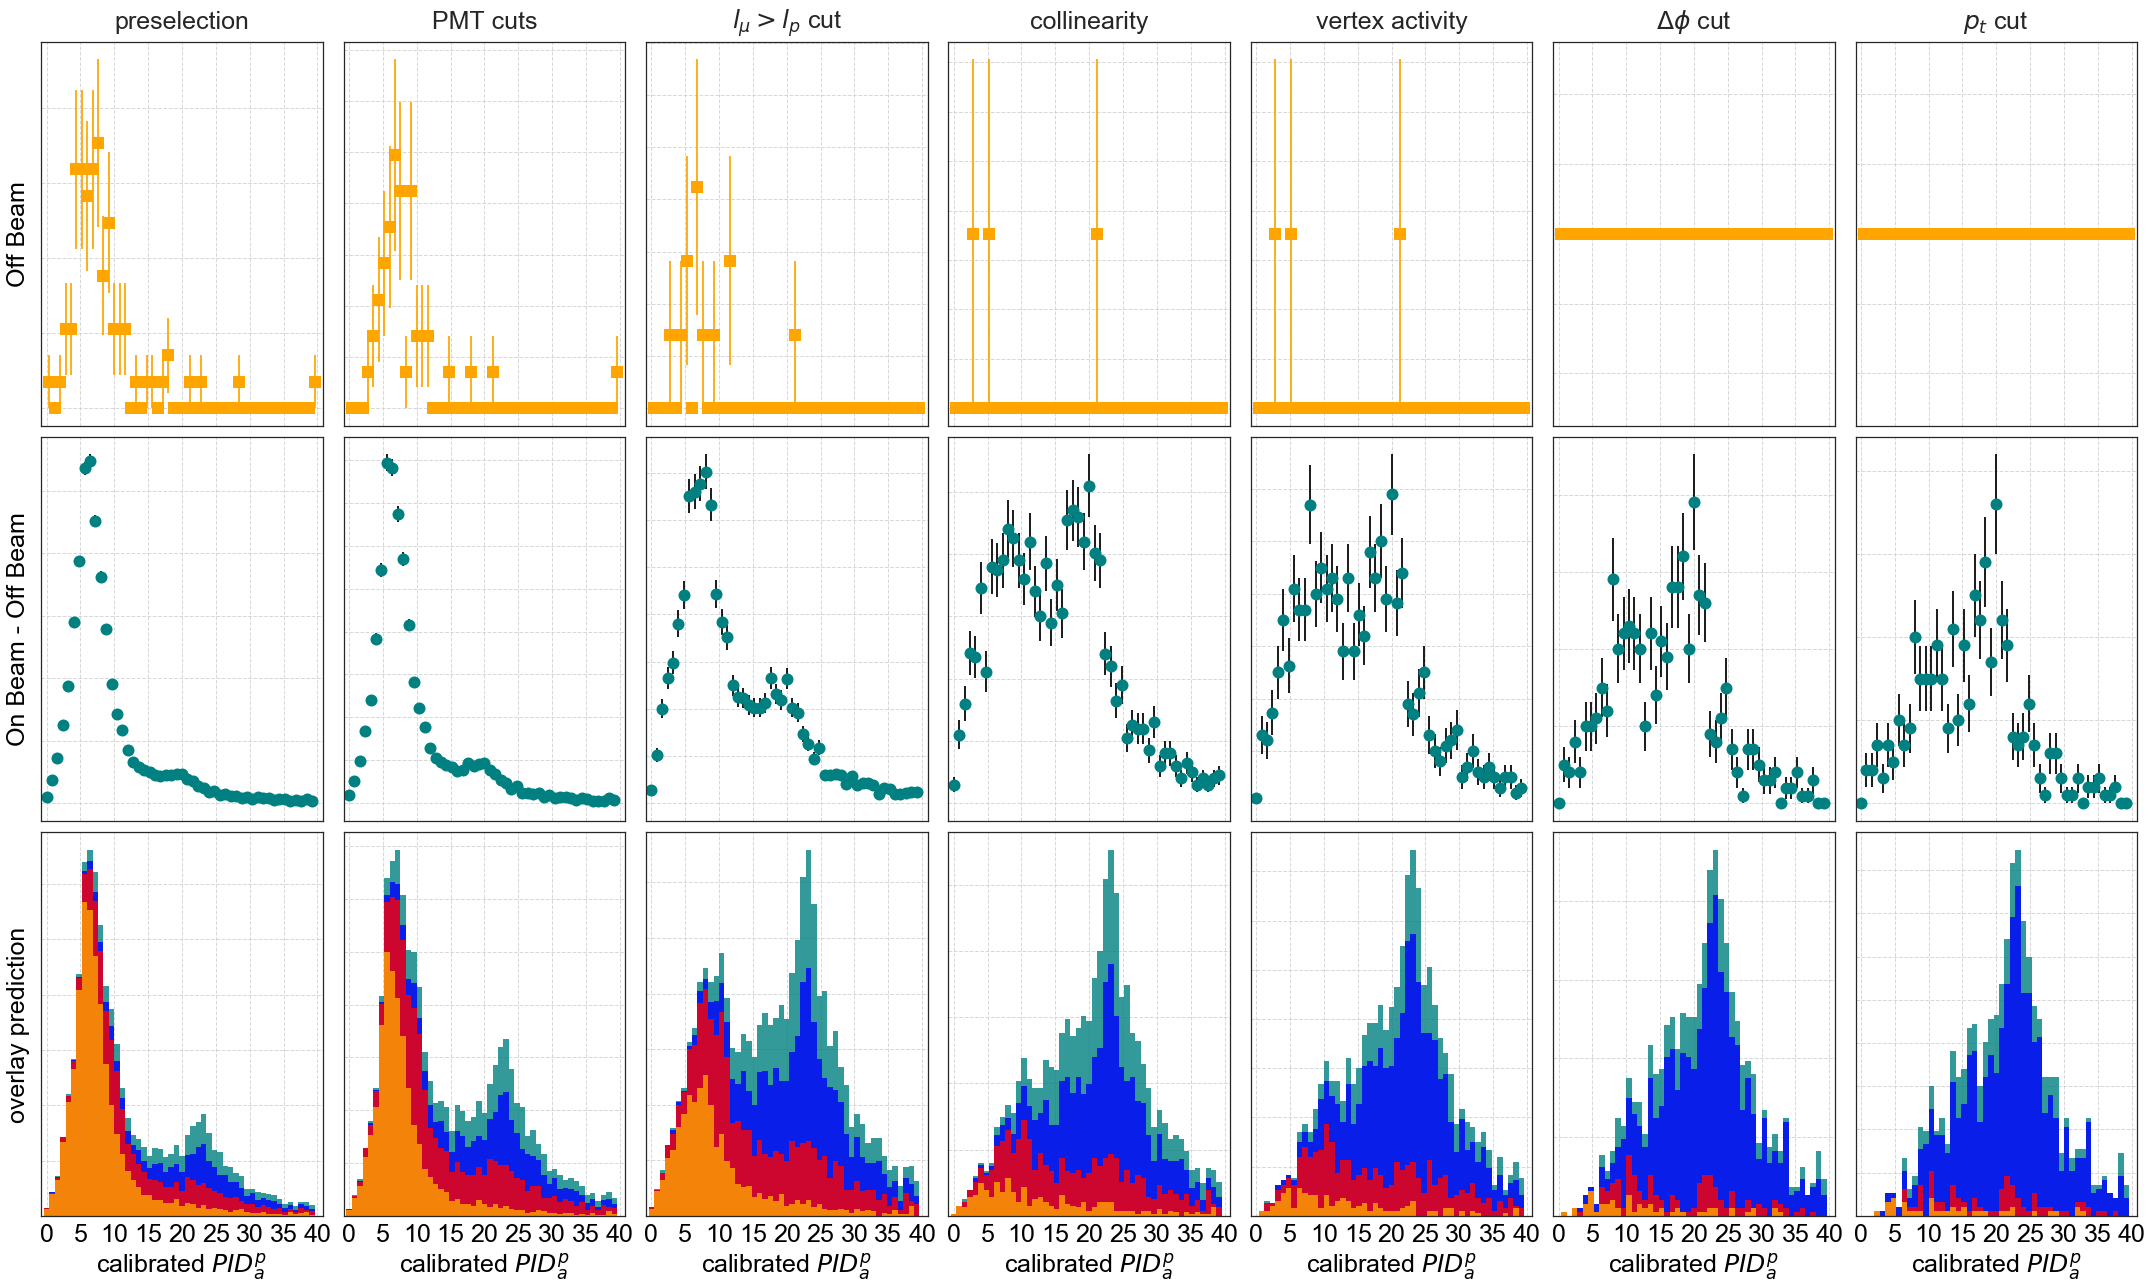

In [31]:
cuts_order  = ['no cut','flash','length','non-collinearity','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PMT cuts',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'

var,x_label,bins='PIDaCali_assigned_proton',r'calibrated $PID_{a}^{p}$',np.linspace(0,40,51)
fig = plt.figure(figsize=(30,18))
for i_cut,(cut_name,cut_label) in enumerate(zip(cuts_order,cuts_labels)):
        
    ax = fig.add_subplot(3,7,i_cut+1)
    plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']                 
                 , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam' if i_cut==0 else ''                 
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=True, remove_ticks_y=True                 
                 , do_OffBeam_scaling=True)
    ax.set_title(cut_label,y=1.02,fontsize=25)
    
    ax = fig.add_subplot(3,7,i_cut+7+1)
    ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True
                                   ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']
                                   ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']
                                   ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' if i_cut==0 else '',remove_ticks_x=True, remove_ticks_y=True
                                   ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False
                                  )  
    ax = fig.add_subplot(3,7,i_cut+14+1)
    plot_stacked_MCsamples( debug=0
                           , MCsamples=reducedOverlay[cut_name]
                           , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                           , var=var, x_label=x_label, y_label='overlay prediction' if i_cut==0 else ''                              
                           , bins=bins , alpha=0.8, ax=ax,remove_ticks_y=True)
    
plt.tight_layout()
filename = figures_path+'PIDaCali_proton_with_cuts.pdf'
plt.savefig(filename, bbox_inches='tight')
print 'saved',filename

# study the evolution of $\Delta \phi$ in On-Off beam without applying the $\Delta \phi$ cut

In [ ]:
cuts_order  = ['no cut','PIDa','flash','length','non-collinearity','vertex activity','soft Pt']
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$p_t$ cut']
reducedOverlay,pureffOverlay = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'

var,x_label,bins='delta_phi',r'$\Delta \phi$ [deg.]',np.linspace(0,360,51)
xticks=[0,100,200,300]

fig = plt.figure(figsize=(30,18))
for i_cut,(cut_name,cut_label) in enumerate(zip(cuts_order,cuts_labels)):
        
    ax = fig.add_subplot(3,7,i_cut+1)
    plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']                 
                 , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam' if i_cut==0 else ''                 
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=True, remove_ticks_y=True                 
                 , do_OffBeam_scaling=True)
    ax.set_title(cut_label,y=1.02,fontsize=25)    
    ax = fig.add_subplot(3,7,i_cut+7+1)
    ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True
                                   ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']
                                   ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']
                                   ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' if i_cut==0 else '',remove_ticks_x=True, remove_ticks_y=True
                                   ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False
                                  )  
    ax = fig.add_subplot(3,7,i_cut+14+1)
    plot_stacked_MCsamples( debug=0
                           , MCsamples=reducedOverlay[cut_name]
                           , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                           , var=var, x_label=x_label, y_label='overlay prediction' if i_cut==0 else ''                              
                           , bins=bins , alpha=0.8, ax=ax,remove_ticks_y=True)
    ax.set_xticks(xticks)
plt.tight_layout()
filename = figures_path+'delta_phi_with_cuts.pdf'
plt.savefig(filename, bbox_inches='tight')
print 'saved',filename

# study the evolution of the collinearity in On-Off beam without applying the $\theta_{1,2}$ cut

In [ ]:
cuts_order  = ['no cut','PIDa','flash','length','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'


var,x_label,bins='theta_12', r'$\theta_{1,2}$ [deg.]',np.linspace(0,180,31)
x_ticks = [0,50,100,150]
fig = plt.figure(figsize=(30,18))

for i_cut,(cut_name,cut_label) in enumerate(zip(cuts_order,cuts_labels)):
        
    ax = fig.add_subplot(3,7,i_cut+1)
    plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut'],remove_ticks_x=True,remove_ticks_y=True                    
                 , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam' if i_cut==0 else ''                 
                 , do_add_legend=False , legend_loc='best'                    
                 , do_OffBeam_scaling=True)
    ax.set_title(cut_label,y=1.02,fontsize=25)
    
    ax = fig.add_subplot(3,7,i_cut+7+1)
    ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True
                                   ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut'],remove_ticks_x=True,remove_ticks_y=True
                                   ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']
                                   ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' if i_cut==0 else ''
                                   ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False
                                  )  

    ax = fig.add_subplot(3,7,i_cut+14+1)
    plot_stacked_MCsamples( debug=0
                           , MCsamples=reducedOverlay[cut_name],remove_ticks_y=True
                           , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                           , var=var, x_label=x_label, y_label='overlay prediction' if i_cut==0 else ''
                           , bins=bins , alpha=0.8, ax=ax)
    ax.set_xticks(x_ticks)
    
plt.tight_layout()
    
filename = figures_path+var+'_with_cuts.pdf'
plt.savefig(filename, bbox_inches='tight')
print 'saved',filename

# study the evolution of $l_{proton-candidate}$ in On-Off beam without applying the $l_p < l_\mu$ cut

In [ ]:
cuts_order  = ['no cut','PIDa','flash','non-collinearity','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PIDa cut','PMT cuts','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'


var,x_label,bins='l_assigned_muon', r'$l_{\mu-candidate}$ [cm]',np.linspace(0,200,51)
x_ticks = [0,60,120,180]
fig = plt.figure(figsize=(30,18))

for i_cut,(cut_name,cut_label) in enumerate(zip(cuts_order,cuts_labels)):
        
    ax = fig.add_subplot(3,7,i_cut+1)
    plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']
                    , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam' if i_cut==0 else ''
                    , do_add_legend=False , legend_loc='best'                    
                 , do_OffBeam_scaling=True)
    ax.get_xaxis().set_major_formatter(NullFormatter())
    ax.set_title(cut_label,y=1.02,fontsize=25)
    ax.get_yaxis().set_major_formatter(NullFormatter())
    
    ax = fig.add_subplot(3,7,i_cut+7+1)
    ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True
                                   ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']
                                   ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']
                                   ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' if i_cut==0 else ''
                                   ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False
                                  )  
    ax.get_xaxis().set_major_formatter(NullFormatter())
    ax.get_yaxis().set_major_formatter(NullFormatter())


    ax = fig.add_subplot(3,7,i_cut+14+1)
    plot_stacked_MCsamples( debug=0
                           , MCsamples=reducedOverlay[cut_name]
                           , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                           , var=var, x_label=x_label, y_label='overlay prediction' if i_cut==0 else ''
                              , bins=bins , alpha=0.8, ax=ax)
    ax.get_yaxis().set_major_formatter(NullFormatter())
    ax.set_xticks(x_ticks)
    
plt.tight_layout()
    
filename = figures_path+var+'_with_cuts.pdf'
plt.savefig(filename, bbox_inches='tight')
print 'saved',filename

# study the evolution of $N_{PE}$ in the closest flash in On-Off beam without applying the PMT cuts

In [ ]:
cuts_order  = ['no cut','PIDa','length','non-collinearity','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PIDa cut',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'


var,x_label,bins='ClosestFlash_TotalPE', r'$N_{PE}^{closest-flash}$',np.linspace(0,1500,31)
x_ticks = [0,400,800,1200]
fig = plt.figure(figsize=(30,18))

for i_cut,(cut_name,cut_label) in enumerate(zip(cuts_order,cuts_labels)):
        
    ax = fig.add_subplot(3,7,i_cut+1)
    plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']
                    , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam' if i_cut==0 else ''
                    , do_add_legend=False , legend_loc='best'                    
                 , do_OffBeam_scaling=True)
    ax.get_xaxis().set_major_formatter(NullFormatter())
    ax.set_title(cut_label,y=1.02,fontsize=25)
    ax.get_yaxis().set_major_formatter(NullFormatter())
    
    ax = fig.add_subplot(3,7,i_cut+7+1)
    ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True
                                   ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']
                                   ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']
                                   ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' if i_cut==0 else ''
                                   ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False
                                  )  
    ax.get_xaxis().set_major_formatter(NullFormatter())
    ax.get_yaxis().set_major_formatter(NullFormatter())


    ax = fig.add_subplot(3,7,i_cut+14+1)
    plot_stacked_MCsamples( debug=0
                           , MCsamples=reducedOverlay[cut_name]
                           , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                           , var=var, x_label=x_label, y_label='overlay prediction' if i_cut==0 else ''
                              , bins=bins , alpha=0.8, ax=ax)
    ax.get_yaxis().set_major_formatter(NullFormatter())
    ax.set_xticks(x_ticks)
    
plt.tight_layout()
    
filename = figures_path+var+'_with_cuts.pdf'
plt.savefig(filename, bbox_inches='tight')
print 'saved',filename

# study the evolution of the vertex activity in On-Off beam without applying the $r_{\Delta Q}$ cut

In [ ]:
cuts_order  = ['no cut','PIDa','flash','length','non-collinearity','delta phi','soft Pt']
cuts_labels = ['preselection','PIDa cut','PMT cuts',r'$l_\mu > l_p$ cut','collinearity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'


var,x_label,bins='RdQaroundVertex[plane 2][50 wires x 100 ticks]', r'$R_{\Delta Q}^{Y}$',np.linspace(-0.1,1.1,51)
x_ticks = [0,0.4,0.8,1.2]
fig = plt.figure(figsize=(30,18))

for i_cut,(cut_name,cut_label) in enumerate(zip(cuts_order,cuts_labels)):
        
    ax = fig.add_subplot(3,7,i_cut+1)
    plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']
                    , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam' if i_cut==0 else ''
                    , do_add_legend=False , legend_loc='best'                    
                 , do_OffBeam_scaling=True)
    ax.get_xaxis().set_major_formatter(NullFormatter())
    ax.set_title(cut_label,y=1.02,fontsize=25)
    ax.get_yaxis().set_major_formatter(NullFormatter())
    
    ax = fig.add_subplot(3,7,i_cut+7+1)
    ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True
                                   ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']
                                   ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']
                                   ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' if i_cut==0 else ''
                                   ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False
                                  )  
    ax.get_xaxis().set_major_formatter(NullFormatter())
    ax.get_yaxis().set_major_formatter(NullFormatter())


    ax = fig.add_subplot(3,7,i_cut+14+1)
    plot_stacked_MCsamples( debug=0
                           , MCsamples=reducedOverlay[cut_name]
                           , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                           , var=var, x_label=x_label, y_label='overlay prediction' if i_cut==0 else ''
                              , bins=bins , alpha=0.8, ax=ax)
    ax.get_yaxis().set_major_formatter(NullFormatter())
    ax.set_xticks(x_ticks)
    
plt.tight_layout()
    
filename = figures_path+'vertex_activity_with_cuts.pdf'
plt.savefig(filename, bbox_inches='tight')
print 'saved',filename

## PIDa

In [ ]:
var,x_label,bins='PIDa_assigned_proton',r'$PID_{a}^{p}$',np.linspace(0,25,51)

cuts_order  = ['no cut','flash','length','non-collinearity','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PMT cuts',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1)
cut_name,cut_label='no cut','preselection'
_,h_OffBeam = plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']
                 , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam' 
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=True, do_OffBeam_scaling=True)
ax.set_title(cut_label,y=1.02,fontsize=25)

plot_stacked_MCsamples( debug=0, MC_scaling=1
                       , MCsamples=reducedOverlay[cut_name]                           
                       , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                       , OverlayCosmicScaling = OverlayCosmicScaling
                       , var=var, x_label=x_label, y_label='overlay prediction'
                       , bins=bins , alpha=0.8, ax=ax);

ax = fig.add_subplot(1,2,2)
cut_name,cut_label='soft Pt','detection+kinematical cuts'
ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True                                   
                           ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']                           
                           ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']                           
                           ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' 
                           ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False)  
ax.set_title(cut_label,y=1.02,fontsize=25)

plot_stacked_MCsamples( debug=0, MC_scaling=MC_scaling_DATAcosmic
                       , MCsamples=reducedOverlay[cut_name]
                       , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                       , OverlayCosmicScaling=OverlayCosmicScaling
                       , var=var, x_label=x_label, y_label='overlay prediction' 
                       , bins=bins , alpha=0.8, ax=ax);
plt.tight_layout()

## number of PE in closest flash

In [ ]:
var,x_label,bins='ClosestFlash_TotalPE', r'$N_{PE}^{closest-flash}$',np.linspace(0,4500,31)
x_ticks = [0,500,1000,1500]

cuts_order  = ['no cut','PIDa','length','non-collinearity','vertex activity','delta phi','soft Pt']
cuts_labels = ['preselection','PIDa cut',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut']
reducedOverlay,pureffOverlay,_ = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples,cuts_order=cuts_order)
print 'done applying cuts to overlay'
reducedOnBeam,reducedOffBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1)
cut_name,cut_label='no cut','preselection'
_,h_OffBeam = plot_OffBeam(OffBeamSample=reducedOffBeam[cut_name],OffBeamFV=reducedOffBeam['no cut']
                 , var=var, x_label='', bins=bins, ax=ax , y_label='Off Beam'
                 , do_add_legend=False , legend_loc='best',remove_ticks_x=False, do_OffBeam_scaling=True)
ax.set_title(cut_label,y=1.02,fontsize=25)

plot_stacked_MCsamples( debug=0, MC_scaling=1
                       , MCsamples=reducedOverlay[cut_name]                           
                       , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                       , OverlayCosmicScaling = OverlayCosmicScaling
                       , var=var, x_label=x_label, y_label='overlay prediction'
                       , bins=bins , alpha=0.8, ax=ax);

ax = fig.add_subplot(1,2,2)
cut_name,cut_label='soft Pt','detection+kinematical cuts'
ax=OnBeam_minus_OffBeam_1d(debug=0,doOffBeam_scaling=True                                   
                           ,OnBeamSample=reducedOnBeam[cut_name] ,OriginalOnBeamSample=reducedOnBeam['no cut']                           
                           ,OffBeamSample=reducedOffBeam[cut_name]  ,OriginalOffBeamSample=reducedOffBeam['no cut']                           
                           ,do_add_MCoverlay=False , y_label='On Beam - Off Beam' 
                           ,var=var , x_label='' ,bins=bins  , ax=ax, do_add_legend=False)  
ax.set_title(cut_label,y=1.02,fontsize=25)

plot_stacked_MCsamples( debug=0
                       , MCsamples=reducedOverlay[cut_name]
                       , MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                       , OverlayCosmicScaling=OverlayCosmicScaling
                       , var=var, x_label=x_label, y_label='overlay prediction' 
                       , bins=bins , alpha=0.8, ax=ax);
plt.tight_layout()

# There seems to be a discrepancy in the number of events: On-Off has much less events after all cuts than the overlay predicts. 
## Can we spot the cut that does that?
Lets look at the number of events as a function of the evolution with cuts 

In [186]:
cuts_order  = ['no cut','flash','length','non-collinearity','vertex activity','delta phi','soft Pt'] #'PIDa',
cuts_labels = ['preselection','PMT cuts',r'$l_\mu > l_p$ cut','collinearity','vertex activity', r'$\Delta \phi$ cut',r'$p_t$ cut'] # 'PIDa cut',
reducedOnBeam,reducedOffBeam,numbersData = apply_cuts_to_data(OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'

grabbing reduced data samples after ( no cut ) and applying cut on ( flash )
len(OnBeam): 24345
len(OffBeam): 20777
grabbing reduced data samples after ( flash ) and applying cut on ( length )
len(OnBeam): 14805
len(OffBeam): 10858
grabbing reduced data samples after ( length ) and applying cut on ( non-collinearity )
len(OnBeam): 5698
len(OffBeam): 3397
grabbing reduced data samples after ( non-collinearity ) and applying cut on ( vertex activity )
len(OnBeam): 2775
len(OffBeam): 1121
grabbing reduced data samples after ( vertex activity ) and applying cut on ( delta phi )
len(OnBeam): 1394
len(OffBeam): 568
grabbing reduced data samples after ( delta phi ) and applying cut on ( soft Pt )
len(OnBeam): 657
len(OffBeam): 179
done applying cuts to data


In [187]:
reducedOverlay,pureffOverlay,numbersOverlay = apply_cuts_to_overlay(MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
                                                                    ,N_On=numbersData.iloc[0]['$N_{On}$']
                                                                    ,cuts_order=cuts_order
                                                                    ,OverlayCosmicScaling=OverlayCosmicScaling
                                                                    ,debug=0)
print '\n done applying cuts to overlay'

N['Cosmic original']: 9486.0
N_On: 24345.0 ,f_Cosmic: 3.97655633659
Noverlay in no cut
{'Cosmic original': 9486.0, 'mup': 5087.0, 'MC': 9422.0, 'Overlay': 18908.0, 'Cosmic Scaled': 37721.613408866251, 'eff Overlay': 1.0, 'Cosmic': 9486.0, 'Overlay Cosmic Scaled': 47143.613408866251, 'Overlay POT Scaled': 9764.1064550522769, 'Overlay Cosmic & POT Scaled': 24345.0, 'others': 4335.0, 'eff Overlay Cosmic Scaled': 1.0}
grabbing reduced samples after ( no cut ) and applying cut on ( flash )
N['Cosmic original']: 9486.0
N_On: 24345.0 ,f_Cosmic: 4.03105770703
Noverlay in flash
{'Cosmic original': 9486.0, 'mup': 4778.0, 'MC': 8905.0, 'Overlay': 13094.0, 'Cosmic Scaled': 16886.100734739695, 'eff Overlay': 0.6925111064099851, 'Cosmic': 4189.0, 'Overlay Cosmic Scaled': 25791.100734739695, 'Overlay POT Scaled': 6761.7521642931306, 'Overlay Cosmic & POT Scaled': 13318.545227785877, 'others': 4127.0, 'eff Overlay Cosmic Scaled': 0.54114076362143093}
grabbing reduced samples after ( flash ) and applyi

In [188]:
numbersOverlay

,"$N_{Overlay, cosmic-scaled}$","$N_{Overlay, cosmic-scaled}^{POT-scaled}$",$N_{Overlay}$,"$N_{cosmic, cosmic-scaled}$","$N_{cosmic, cosmic-scaled}^{POT-scaled}$",$N_{cosmic}$,"${\epsilon}_{Overlay, cosmic-scaled}$ [%]",${\epsilon}_{Overlay}$ [%]
preselection,47143.61,24345.00,18908.0,37721.61,19479.47,9486.0,100.00,100.00
flash,25791.10,13318.55,13094.0,16886.10,8720.00,4189.0,54.11,69.25
length,11815.60,6101.58,7173.0,6024.60,3111.11,1382.0,23.27,37.94
non-collinearity,6747.68,3484.51,5123.0,2091.68,1080.15,467.0,13.00,27.09
vertex activity,4193.79,2165.68,3285.0,1157.79,597.88,249.0,7.83,17.37
delta phi,2062.44,1065.05,1782.0,354.44,183.03,74.0,3.76,9.42
soft Pt,1659.28,856.85,1499.0,202.28,104.46,42.0,3.01,7.93


In [182]:
numbersOverlay[['$N_{cosmic}$','$N_{cosmic, cosmic-scaled}$','$N_{cosmic, cosmic-scaled}^{POT-scaled}$']]

,$N_{cosmic}$,"$N_{cosmic, cosmic-scaled}$","$N_{cosmic, cosmic-scaled}^{POT-scaled}$"
preselection,9486.0,37721.61,19479.47
preselection,4189.0,16886.10,8720.00
preselection,1382.0,6024.60,3111.11
preselection,467.0,2091.68,1080.15
preselection,249.0,1157.79,597.88
preselection,74.0,354.44,183.03
preselection,42.0,202.28,104.46


In [189]:
numbersOverlay[['$N_{Overlay}$',r'${\epsilon}_{Overlay}$ [%]'
                ,'$N_{Overlay, cosmic-scaled}^{POT-scaled}$',r'${\epsilon}_{Overlay, cosmic-scaled}$ [%]']]

,$N_{Overlay}$,${\epsilon}_{Overlay}$ [%],"$N_{Overlay, cosmic-scaled}^{POT-scaled}$","${\epsilon}_{Overlay, cosmic-scaled}$ [%]"
preselection,18908.0,100.00,24345.00,100.00
flash,13094.0,69.25,13318.55,54.11
length,7173.0,37.94,6101.58,23.27
non-collinearity,5123.0,27.09,3484.51,13.00
vertex activity,3285.0,17.37,2165.68,7.83
delta phi,1782.0,9.42,1065.05,3.76
soft Pt,1499.0,7.93,856.85,3.01


In [190]:
numbersData[['$N_{On}$',r'${\epsilon}_{On}$ [%]'
             ,'$N_{Off}$',r'${\epsilon}_{Off}$ [%]','$N_{Off}^{scaled}$'
             ,'$N_{On-Off}$',r'${\epsilon}_{On-Off}$ [%]']]

,$N_{On}$,${\epsilon}_{On}$ [%],$N_{Off}$,${\epsilon}_{Off}$ [%],$N_{Off}^{scaled}$,$N_{On-Off}$,${\epsilon}_{On-Off}$ [%]
preselection,24345,100.00,20777,100.00,14677.36,9667.64,100.00
flash,14805,60.81,10858,52.26,7670.35,7134.65,73.80
length,5698,23.41,3397,16.35,2399.72,3298.28,34.12
non-collinearity,2775,11.40,1121,5.40,791.90,1983.10,20.51
vertex activity,1394,5.73,568,2.73,401.25,992.75,10.27
delta phi,657,2.70,179,0.86,126.45,530.55,5.49
soft Pt,520,2.14,108,0.52,76.29,443.71,4.59


In [171]:
pureffOverlay

,$\mu p$ eff.,$\mu p$ pur.,CC$0\pi 1 p$ eff.,CC$0\pi 1 p$ pur.,label,1mu-1p,other pairs,cosmic,CC 1p 0pi
no cut,100.0%,26.9%,100.0%,13.3%,no cut,100.0% (5087),100.0% (4335),100.0% (9486),100.0% (2514)
flash,93.9%,36.5%,93.8%,18.0%,flash,93.9% (4778),95.2% (4127),44.2% (4189),93.8% (2358)
length,74.3%,52.7%,78.2%,27.4%,length,74.3% (3781),46.4% (2010),14.6% (1382),78.2% (1966)
non-collinearity,66.3%,65.8%,72.5%,35.6%,non-collinearity,66.3% (3373),29.6% (1283),4.9% (467),72.5% (1823)
vertex activity,44.8%,69.3%,61.6%,47.2%,vertex activity,44.8% (2277),17.5% (759),2.6% (249),61.6% (1549)
delta phi,30.1%,86.0%,47.5%,67.0%,delta phi,30.1% (1533),4.0% (175),0.8% (74),47.5% (1194)
soft Pt,26.6%,90.3%,42.7%,71.6%,soft Pt,26.6% (1354),2.4% (103),0.4% (42),42.7% (1074)


In [ ]:
reduced_OffBeam = dict()
reduced_OnBeam = dict()

reduced_OffBeam['no cut'] = OffBeamFV
reduced_OnBeam['no cut'] = OnBeamFV

# cut 3: |\theta_{1,2}-90^0|<60^0$
theta_12_cut = 60
sam = reduced_OffBeam['no cut']
reduced_OffBeam['non-collinearity first'] = sam[np.abs(sam['theta_12']-90)<theta_12_cut]
sam = reduced_OnBeam['no cut']
reduced_OnBeam['non-collinearity first'] = sam[np.abs(sam['theta_12']-90)<theta_12_cut]



# cut 1: PIDa
PIDaCut = 12
sam = reduced_OffBeam['no cut']
reduced_OffBeam['PIDa'] = sam[sam['PIDa_assigned_proton']>PIDaCut]
sam = reduced_OnBeam['no cut']
reduced_OnBeam['PIDa'] = sam[sam['PIDa_assigned_proton']>PIDaCut]


# cut 2: require that the longer track is the one with larger PIDa
sam = reduced_OffBeam['PIDa']
reduced_OffBeam['length'] = sam[sam['PIDa_long'] < sam['PIDa_short']]
sam = reduced_OnBeam['PIDa']
reduced_OnBeam['length'] = sam[sam['PIDa_long'] < sam['PIDa_short']]


# cut 3: |\theta_{1,2}-90^0|<60^0$
theta_12_cut = 60
sam = reduced_OffBeam['length']
reduced_OffBeam['non-collinearity'] = sam[np.abs(sam['theta_12']-90)<theta_12_cut]
sam = reduced_OnBeam['length']
reduced_OnBeam['non-collinearity'] = sam[np.abs(sam['theta_12']-90)<theta_12_cut]


# cut 4: vertex activity
opt_box=(50,100)
box_str='[%d wires x %d ticks]'%(opt_box[0],opt_box[1])
Ru = 'RdQaroundVertex[plane 0]'+box_str
Rv = 'RdQaroundVertex[plane 1]'+box_str
Ry = 'RdQaroundVertex[plane 2]'+box_str    
r_max_RdQ_CC1p0pi = 0.33
sam = reduced_OffBeam['non-collinearity']
reduced_OffBeam['vertex activity'] = sam[(sam[Ru]==1) | (sam[Rv]==1) | (sam[Ry]==1) 
                                         | 
                                         (np.sqrt( np.square(sam[Ru]-1) 
                                                  + np.square(sam[Rv]-1) 
                                                  + np.square(sam[Ry]-1) ) <= r_max_RdQ_CC1p0pi) ]
sam = reduced_OnBeam['non-collinearity']
reduced_OnBeam['vertex activity'] = sam[(sam[Ru]==1) | (sam[Rv]==1) | (sam[Ry]==1) 
                                         | 
                                         (np.sqrt( np.square(sam[Ru]-1) 
                                                  + np.square(sam[Rv]-1) 
                                                  + np.square(sam[Ry]-1) ) <= r_max_RdQ_CC1p0pi) ]


# cut 5: \Delta \phi
delta_Delta_phi = 40
sam = reduced_OffBeam['vertex activity']
reduced_OffBeam['delta phi'] = sam[np.abs(sam['delta_phi']-180.)<delta_Delta_phi]
sam = reduced_OnBeam['vertex activity']
reduced_OnBeam['delta phi'] = sam[np.abs(sam['delta_phi']-180.)<delta_Delta_phi]


# modified cut 6: $p_{t}<0.35$
Pt_max = 0.35
sam = reduced_OffBeam['delta phi']
reduced_OffBeam['soft Pt'] = sam[sam['reco_Pt']<Pt_max]
sam = reduced_OnBeam['delta phi']
reduced_OnBeam['soft Pt'] = sam[sam['reco_Pt']<Pt_max]

# cut on l_p>10 cm
sam = reduced_OffBeam['soft Pt']
reduced_OffBeam['l_p_min_10'] = sam[sam['l_assigned_proton']>10]
sam = reduced_OnBeam['soft Pt']
reduced_OnBeam['l_p_min_10'] = sam[sam['l_assigned_proton']>10]

# lets get to buissiness

In [ ]:
#     draw_var(cut_name='soft Pt',var='reco_Q2',x_label='$Q^2$ (GeV/c)$^2$',bins=np.linspace(0.0,1.0,25)
#              ,reduced_OnBeam=reduced_OnBeam
#              ,reduced_OffBeam=reduced_OffBeam,MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
#              ,do_cosmic_only=False
#              ,do_bnb_only=True
#              ,chi2_xrange=(0,1),chi2_xy=(0.6,50)
#              ,debug=2,do_save_fig=True)
draw_var(cut_name='soft Pt',var='l_assigned_proton',x_label='$l^p$ [cm]'         
         ,OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV
         ,bins=np.linspace(0,100,41)
         ,chi2_xrange=(0,100),chi2_xy=(20,50)
         ,reduced_OnBeam=reduced_OnBeam
         ,reduced_OffBeam=reduced_OffBeam
         ,reduced_MCbnbDATAcosmicSamples=reduced_MCbnbDATAcosmicSamples
         ,MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
         ,do_cosmic_only=False,do_bnb_only=True         
         ,debug=2,do_save_fig=True,figures_path=figures_path)    

In [ ]:
cut_name = 'soft Pt' # 'no cut','non-collinearity first',
observables = ['l_assigned_muon','l_assigned_proton','PIDa_assigned_proton','PIDa_assigned_muon','theta_12','delta_phi','reco_Pt','reco_Q2']
x_labels = [r'$l_{\mu}$ [cm]',r'$l_{p}$ [cm]',r'$PID_a^{p}$',r'$PID_a^{\mu}$',r'$\theta^{12}$ [deg.]',r'$\Delta \phi$ [deg.]','$p_{t}$ [GeV/c]','$Q^2$ (GeV/c)$^2$']
x_bins = [np.linspace(0,210,31),np.linspace(0,100,41),np.linspace(0,40,41),np.linspace(0,40,41),np.linspace(0,180,31),np.linspace(0,360,73),np.linspace(0.0,0.7,21),np.linspace(0.0,1.0,25)]
chi2_xranges = [(0,210),(0,70),(12,40),(0,20),(30,150),(140,220),(0,0.4),(0,1)]
chi2_xy_text = [(100,30),(20,60),(25,40),(10,60),(30,35),(220,70),(0.4,50),(0.6,50)]
for var,x_label,bins,chi2_xrange,chi2_xy in zip(observables
                                                 ,x_labels
                                                 ,x_bins
                                                 ,chi2_xranges
                                                 ,chi2_xy_text):
    draw_var(cut_name=cut_name,var=var,x_label=x_label,bins=bins
             ,OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV
             ,reduced_OnBeam=reduced_OnBeam
             ,reduced_OffBeam=reduced_OffBeam
             ,reduced_MCbnbDATAcosmicSamples=reduced_MCbnbDATAcosmicSamples
             ,MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
             ,do_cosmic_only=False
             ,do_bnb_only=True
             ,chi2_xrange=chi2_xrange,chi2_xy=chi2_xy
             ,debug=0,do_save_fig=True,figures_path=figures_path)

# 2D

In [ ]:
cut_name = 'soft Pt'
varx='l_assigned_proton'
x_label=r'$l^{p}$ [cm]'
vary='PIDa_assigned_proton'
y_label=r'$PID_a^{p}$'
OnBeam_minus_OffBeam_2d( OnBeamSample=reduced_OnBeam[cut_name] , OffBeamSample=reduced_OffBeam[cut_name]
                        , debug=0                        
                        , varx=varx , x_label=x_label
                        , vary=vary , y_label=y_label
                        , bins=(np.linspace(0,100,41),np.linspace(0,40,41)), cmap='RdBu_r'
                        )
filename = figures_path+varx+"_vs_"+vary+'_'+'after_cut_'+cut_name+'.pdf'
print 'saved', filename
plt.savefig(filename)

OnBeam_minus_OffBeam_2d( OnBeamSample=reduced_OnBeam[cut_name] , OffBeamSample=reduced_OffBeam[cut_name]
                        , debug=0                        
                        , varx=varx , x_label=x_label
                        , vary=vary , y_label=y_label
                        , bins=(np.linspace(0,20,21),np.linspace(12,40,29)), cmap='RdBu_r'
                        )
filename = figures_path+varx+"_vs_"+vary+'_'+'after_cut_'+cut_name+'_zoomin_'+'.pdf'
print 'saved', filename
plt.savefig(filename)

# after a cut on $l_p>10$ cm

In [ ]:
draw_var(cut_name='l_p_min_10',var='PIDa_assigned_proton',x_label=r'$PID_a^p$'
         ,bins=np.linspace(0,40,41)
         ,chi2_xrange=(12,40),chi2_xy=(20,50)
             ,OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV
             ,reduced_OnBeam=reduced_OnBeam
             ,reduced_OffBeam=reduced_OffBeam
             ,reduced_MCbnbDATAcosmicSamples=reduced_MCbnbDATAcosmicSamples
             ,MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
             ,do_cosmic_only=False
             ,do_bnb_only=True
         ,debug=0,do_save_fig=True,figures_path=figures_path)    

# before kinematical cuts

In [ ]:
draw_var(cut_name='vertex activity',var='theta_12',x_label=r'$\theta^{12}$ [deg.]'
         ,bins=np.linspace(0,180,31)
         ,chi2_xrange=(30,150),chi2_xy=(20,50)
               ,OnBeamFV=OnBeamFV,OffBeamFV=OffBeamFV
             ,reduced_OnBeam=reduced_OnBeam
             ,reduced_OffBeam=reduced_OffBeam
             ,reduced_MCbnbDATAcosmicSamples=reduced_MCbnbDATAcosmicSamples
             ,MCbnbDATAcosmicSamples=MCbnbDATAcosmicSamples
             ,do_cosmic_only=False
             ,do_bnb_only=True
         ,debug=0,do_save_fig=True,figures_path=figures_path)    